In [134]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [135]:
def f(x):
    return 3*x**2 - 4*x + 5

In [136]:
xs = np.arange(-5, 5, 0.25)

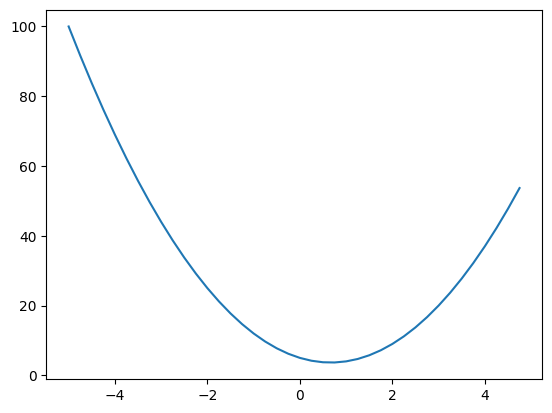

In [137]:
xs
ys = f(xs)
plt.plot(xs, ys)

In [138]:
# Derivates
h = 0.000001
x = 2/3
(f(x+h) - f(x))/h

2.999378523327323e-06

In [139]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c
print('d1', d1)
print('d2', d2)
print('slope', (d1-d2)/h)

d1 4.0
d2 3.999699999999999
slope 3.000000000010772


In [172]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        n = self.data
        t = (math.exp(2*n)-1)/(math.exp(2*n)+1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def backward(self):
        # topological sort for managing gradient dependencies

        topo = []
        visited = set()

        def build_topo(v): 
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
            topo.append(v)

        build_topo(self)

        self.grad = 1
        for node in reversed(topo):
            node._backward()

In [141]:
from graphviz import Digraph

def trace(root):

    nodes, edges = set(), set()
    
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}, filename="DigraphView.svg") # LR -> left to right direction

    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape="record") # node for any value
        if n._op: # node for Value obtained from any operation
            dot.node(name=uid+n._op, label=n._op)
            dot.edge(uid+n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the operation node of n2, which is the also the operation node of result of n1 and n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [142]:
h = 0.000001

a = Value(2.0, label='a')
b = Value(-1, label='b')
c = Value(4.0, label='c')
e = Value(10.0, label='e')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'

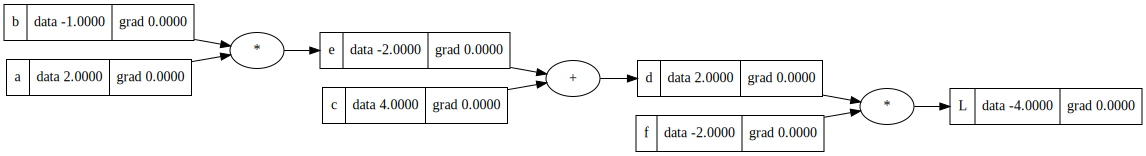

In [143]:
draw_dot(L)

In [144]:
def lol():

    h = 0.000001

    a = Value(2.0, label='a')
    b = Value(-1, label='b')
    c = Value(4.0, label='c')
    e = Value(10.0, label='e')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0 + h, label='a')
    b = Value(-1, label='b')
    c = Value(4.0, label='c')
    e = Value(10.0, label='e')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print((L2 - L1)/h)

lol()

2.000000000279556


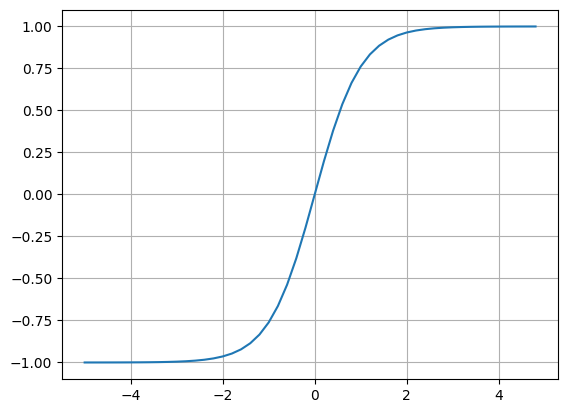

In [145]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid();

In [146]:
# 2 dimension neuron
# inputs x1, x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# weights w1, w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

# bias of the neuron
b = Value(6.7, label="b")

x1w1 = x1 * w1; x1w1.label = "x1*w1"
x2w2 = x2 * w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1 + x2w2"
n = x1w1x2w2 + b; n.label="n"
o = n.tanh(); o.label="o"

## Backpropagation

In [147]:
# o = tanh(n)
# do/dn = 1 - o**2
1 - o.data ** 2

0.6347395899824584

In [148]:
o.grad = 1.0
o.data

0.6043677771171636

In [149]:
n.grad = 0.6347395899824584

In [150]:
x1w1x2w2.grad = 0.6347395899824584
b.grad = 0.6347395899824584

In [151]:
x1w1.grad = 0.6347395899824584
x2w2.grad = 0.6347395899824584

In [152]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

In [153]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

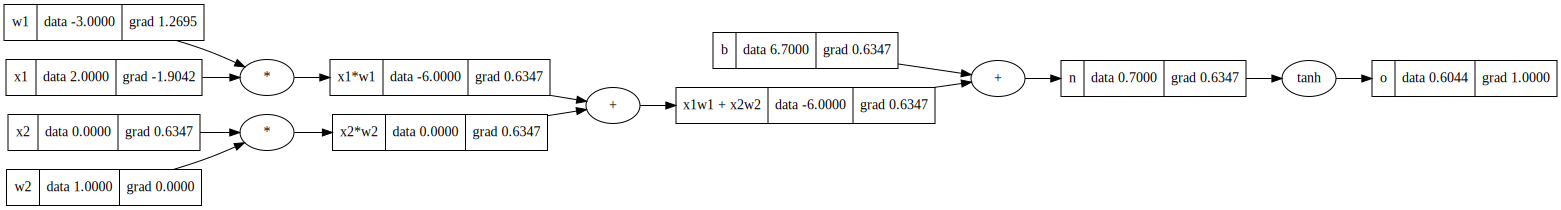

In [154]:
draw_dot(o)

In [173]:
# with backpropagation implemented
# 2 dimension neuron
# inputs x1, x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# weights w1, w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

# bias of the neuron
b = Value(6.7, label="b")

x1w1 = x1 * w1; x1w1.label = "x1*w1"
x2w2 = x2 * w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1 + x2w2"
n = x1w1x2w2 + b; n.label="n"
o = n.tanh(); o.label="o"

In [168]:
o.grad = 1

In [156]:
o._backward()

In [157]:
n._backward()

In [158]:
b._backward()

In [159]:
x1w1x2w2._backward()

In [160]:
x1w1._backward()
x2w2._backward()

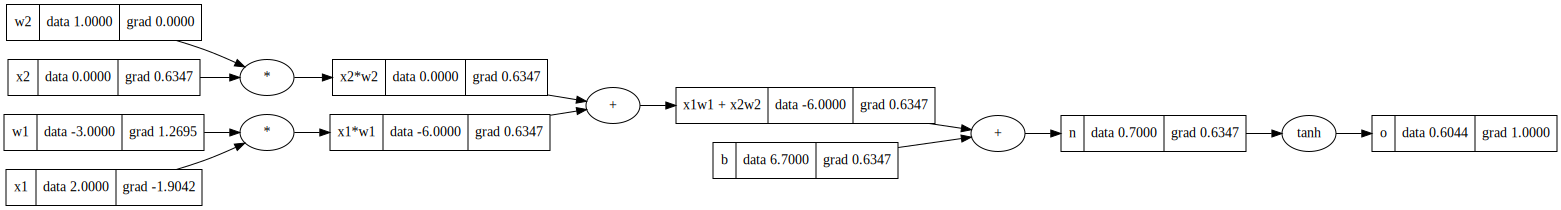

In [176]:
draw_dot(o)

In [170]:
# topological sort for managing gradient dependencies

topo = []
visited = set()

def build_topo(v): 
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
    topo.append(v)

build_topo(o)
print(topo)

for node in reversed(topo):
    node._backward()

[Value(data=6.7), Value(data=2.0), Value(data=-3.0), Value(data=-6.0), Value(data=0.0), Value(data=1.0), Value(data=0.0), Value(data=-6.0), Value(data=0.7000000000000002), Value(data=0.6043677771171636)]


In [175]:
o.backward()